## Introduction

AirSeaFluxCode is developed to provide an easy and accessible way to calculate turbulent surface fluxes (TSFs) from a small number of bulk variables and for a viariety of bulk algorithms. 

By running AirSeaFluxCode you can compare different bulk algorithms and to also investigate the effect choices within the implementation of each parameterisation have on the TSFs estimates. 


### Getting started

Let's first import the basic python packages we will need for reading in our input data, to perform basic statistics  and plotting

In [1]:
# first import all packages you might need
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import pandas as pd
from tabulate import tabulate

/var/folders/vf/pskk3w4j38l8kk7bc9xm07j00000gp/T/ipykernel_75435/3237468643.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### AirSeaFluxCode examples

AirSeaFluxCode is set up to run in its default setting with a minimum number of input variables, namely wind speed; air temperature; and sea surface temperature. Let's load the code, import some real data composed for testing it (Research vessel data) and run AirSeaFluxCode with default settings (output height 10m, cool skin/warm layer corrections turned off, bulk algorithm Smith 1988, gustiness on, saturation vapour pressure following Buck (2012), tolerance limits set for both flux estimates and height adjusted variables (['all', 0.01, 0.01, 1e-05, 1e-3, 0.1, 0.1]), number of iterations are ten, non converged points are set to missing and Monin-Obukhov stability length is calculated following the ECMWF implementation.

In [2]:
from AirSeaFluxCode import AirSeaFluxCode

In [3]:
inDt = pd.read_csv("test/data/data_all.csv")
date = np.asarray(inDt["Date"])
lon = np.asarray(inDt["Longitude"])
lat = np.asarray(inDt["Latitude"])
spd = np.asarray(inDt["Wind speed"])
t = np.asarray(inDt["Air temperature"])
sst = np.asarray(inDt["SST"])
rh = np.asarray(inDt["RH"])
p = np.asarray(inDt["P"])
sw = np.asarray(inDt["Rs"])
hu = np.asarray(inDt["zu"])
ht = np.asarray(inDt["zt"])
hin = np.array([hu, ht, ht])
del hu, ht, inDt
outvar = ("tau", "sensible", "latent", "u10n", "t10n", "q10n")
# run AirSeaFluxCode
res = AirSeaFluxCode(spd, t, sst, "bulk", meth="UA", lat=lat, hin=hin, hum=["rh", rh], P=p, cskin=0, Rs=sw,
                     tol=['all', 0.01, 0.01, 1e-2, 1e-3, 0.1, 0.1], L="tsrv", out_var = outvar)
flg = res["flag"]

res is the output of AirSeaFluxCode which is a dataFrame with keys: "tau", "sensible", "latent", "u10n", "t10n", "q10n". Let's plot the flux estimates.

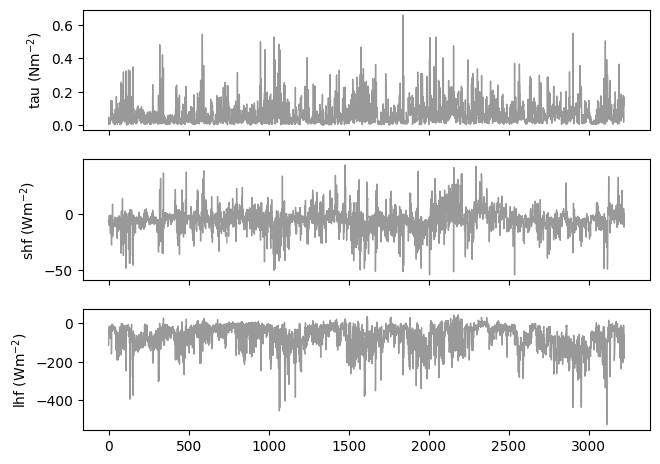

In [4]:
fig, ax = plt.subplots(3, 1, sharex=True, sharey=False)
fig.tight_layout()
ax[0].plot(res["tau"], "-", color="grey", linewidth=1, alpha = 0.8)
ax[1].plot(res["sensible"], "-", color="grey", linewidth=1, alpha = 0.8)
ax[2].plot(res["latent"], "-", color="grey", linewidth=1, alpha = 0.8)
ax[0].set_ylabel('tau (Nm$^{-2}$)')
ax[1].set_ylabel('shf (Wm$^{-2}$)')
ax[2].set_ylabel('lhf (Wm$^{-2}$)')
plt.show()

You can save the output in a csv file

In [5]:
res.to_csv("test_AirSeaFluxCode.csv")

and generate some statistics which you can save in a txt file

In [6]:
print("Input summary", file=open('./stats.txt', 'a'))
print('input file name: {}, \n method: {}, \n gustiness: {}, \n cskin: {},'
      ' \n tolerance: {}, \n qmethod: {}, \n L: {}'.format("data_all.csv", "UA", "on",
                                                           0, "all", "Buck2", "Rb"),
      file=open('./stats.txt', 'a'))
ttl = np.asarray(["tau  ", "shf  ", "lhf  ", "u10n ", "t10n ", "q10n "])
header = ["var", "mean", "median", "min", "max", "5%", "95%"]
n = np.shape(res)
stats = np.copy(ttl)
a = res.iloc[:,:-1].to_numpy(dtype="float64").T
stats = np.c_[stats, np.nanmean(a, axis=1)]
stats = np.c_[stats, np.nanmedian(a, axis=1)]
stats = np.c_[stats, np.nanmin(a, axis=1)]
stats = np.c_[stats, np.nanmax(a, axis=1)]
stats = np.c_[stats, np.nanpercentile(a, 5, axis=1)]
stats = np.c_[stats, np.nanpercentile(a, 95, axis=1)]
print(tabulate(stats, headers=header, tablefmt="github", numalign="left",
               floatfmt=("s", "2.2e", "2.2e", "2.2e", "2.2e", "2.2e", "2.2e")),
      file=open('./stats.txt', 'a'))
print('-'*79+'\n', file=open('./stats.txt', 'a'))
del a